In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

# 자신의 Google Drive 마운트하는 코드를 추가하자!
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
filepath = '/content/gdrive/MyDrive' + '/Colab Notebooks/csv/'
mnist = np.load(filepath + 'mnist.npz')

x_train = (mnist['x_train'] - np.mean(mnist['x_train'])) / np.std(mnist['x_train'])
y_train = mnist['y_train']
x_test = (mnist['x_test'] - np.mean(mnist['x_train'])) / np.std(mnist['x_train'])
y_test = mnist['y_test']

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Mounted at /content/gdrive
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [2]:
from torch.utils.data import TensorDataset, DataLoader

# Train Data Set
train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# Test Data Set
test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test))
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512, bias=False)
        self.fc2 = nn.Linear(512, 512, bias=False)
        self.fc3 = nn.Linear(512, 10, bias=False)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [4]:
from torch.optim import SGD, Adagrad, RMSprop, Adam

model = MLP().to(device)
criterion = nn.CrossEntropyLoss().to(device)

# Optimization 방법을 변경해보면서 학습속도를 비교해보자!
# opti = SGD(model.parameters(), lr=1e-3) # Basic Stochastic Gradient Descent
# opti = SGD(model.parameters(), lr=1e-3, momentum=0.9) # Momentum
# opti = Adagrad(model.parameters(), lr=1e-3) # Adagrad
# opti = RMSprop(model.parameters(), lr=1e-3, alpha=0.99) # RMSprop
opti = Adam(model.parameters(), lr=1e-3) # Adam

# 다양성을 원한다면, Momentum이 존재하는 초기화 기법이 좋음
# Local Mimima에 상관없이 빠르게 결과를 보고싶다면 Gradient만 존재하는 기법 사용
# 일반적으로 가장 많이 사용되는 것은 Adam이다. (잘 모르면 Adam을 사용하자.)

In [5]:
def train(model, dataloader, criterion, data_len, opti):
    correct = 0

    model.train()
    for data, target in dataloader:
        data = data.view(-1, 28*28).to(device)
        target = target.to(device)

        output = model(data)
        loss = criterion(output, target)

        opti.zero_grad()
        loss.backward()
        opti.step()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100 * correct / data_len
    return acc

In [6]:
def evalutate(model, dataloader, criterion, data_len):
    correct = 0

    model.eval()
    for data, target in dataloader:
        data = data.view(-1, 28*28).to(device)
        target = target.to(device)

        output = model(data)
        loss = criterion(output, target)

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100 * correct / data_len
    return acc

In [7]:
def predict(model, dataloader):
    output_list = []

    model.eval()
    for data, target in dataloader:
        data = data.view(-1, 28*28).to(device)
        target = target.to(device)

        output = model(data)
        output_list += output.tolist()
    
    return np.array(output_list)

In [8]:
epoch = 10

for i in range(epoch):
    train_acc = train(model, train_dl, criterion, len(train_dl.dataset), opti)
    val_acc = evalutate(model, test_dl, criterion, len(test_dl.dataset))

    print(i, train_acc, val_acc)

0 92.41833333333334 97.08
1 95.71166666666667 97.73
2 96.42166666666667 97.78
3 96.97 97.86
4 97.29166666666667 98.17
5 97.63666666666667 98.3
6 97.73166666666667 98.38
7 97.955 98.31
8 98.175 98.4
9 98.225 98.52


In [9]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR, CyclicLR

opti = Adam(model.parameters(), lr=1e-2)

# scheduler = StepLR(opti, step_size=50, gamma=0.75)
# scheduler = ExponentialLR(opti, gamma=0.98)
scheduler = CosineAnnealingLR(opti, T_max=100, eta_min=1e-3)
# scheduler = CyclicLR(opti, base_lr=1e-2, max_lr=1e-1, step_size_up=50, step_size_down=100, mode="triangular", cycle_momentum=False)

lrs = []
for i in range(1000):
    lrs.append(scheduler.get_last_lr())

    opti.step()
    scheduler.step()
lrs = np.array(lrs)

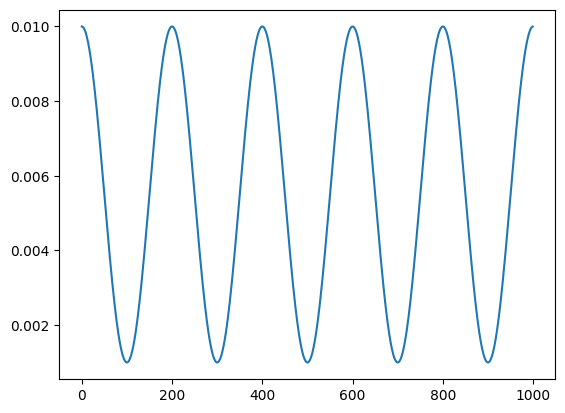

In [10]:
import matplotlib.pyplot as plt

plt.plot(lrs)
plt.show()

In [11]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

k_num = 4
kfold = KFold(n_splits=k_num, shuffle=True)

In [12]:
epoch = 10
models = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    train_dl = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
    val_dl = DataLoader(train_dataset, batch_size=32, sampler=val_subsampler)

    model = MLP().to(device)
    opti = Adam(model.parameters(), lr=1e-3)

    for i in range(epoch):
        train_acc = train(model, train_dl, criterion, len(train_subsampler), opti)
        val_acc = evalutate(model, val_dl, criterion, len(val_subsampler))
        print(fold, i, train_acc, val_acc)
        
    print()
    models.append(model)

0 0 91.82666666666667 96.60666666666667
0 1 95.32666666666667 97.36
0 2 96.12666666666667 97.59333333333333
0 3 96.65333333333334 97.68666666666667
0 4 97.04888888888888 97.95333333333333
0 5 97.36222222222223 97.76
0 6 97.69111111111111 97.98
0 7 97.75777777777778 98.06666666666666
0 8 97.96666666666667 98.23333333333333
0 9 98.13777777777777 98.2

1 0 91.64444444444445 95.96
1 1 95.2911111111111 96.98666666666666
1 2 96.18222222222222 97.49333333333334
1 3 96.69777777777777 97.52
1 4 97.09555555555555 97.77333333333333
1 5 97.36666666666666 97.76666666666667
1 6 97.58888888888889 97.88
1 7 97.76222222222222 97.98666666666666
1 8 98.03777777777778 97.89333333333333
1 9 98.07555555555555 98.22

2 0 91.67555555555556 96.18666666666667
2 1 95.29777777777778 96.85333333333334
2 2 96.14666666666666 97.27333333333333
2 3 96.67555555555556 97.43333333333334
2 4 97.07333333333334 97.54666666666667
2 5 97.40222222222222 97.6
2 6 97.71777777777778 97.67333333333333
2 7 97.91777777777777 97.8466

In [13]:
test_dl =  DataLoader(test_dataset, batch_size=32, shuffle=False)

outputs = []
for model in models:
    test_acc = evalutate(model, test_dl, criterion, len(test_dataset))
    print(test_acc)

    output = predict(model, test_dl)
    outputs.append(output)

outputs = np.sum(np.array(outputs), axis=0) # 평균을 해도 상관이 없음,
y_pred = np.argmax(outputs, axis=-1)

98.13
98.06
98.23
98.13


In [14]:
from sklearn.metrics import accuracy_score

y_true = []
for _, target in test_dl:
    y_true += target.tolist()

y_true = np.array(y_true).reshape(-1, )
print(accuracy_score(y_true, y_pred) * 100.)

98.59
